In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import random

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import max_error, mean_squared_error
from sklearn.model_selection import learning_curve

In [ ]:
def read_dataset(filename):
# Input:    - filename: name of data file (it may even include the entire path in case it is in a subfolder)
# Outputs:  The function should return:
#           1. List with spans lengths for all the lightpaths (each element of the list corresponds to one lightpath
#              and is itself a list of variable len(), depending on the number of spans for that lightpath)
#           2. List with interferer info for all the lightpaths (each element of the list corresponds to one lightpath
#              and is itself a list with len()=2). For each lightpath, the list should include:
#               2.1. maximum number of interferers across the links of the path, and
#               2.2. distance to the closest intereferer across the links of the path [GHz]
#           3. List of SNR values for each lightpath [dB]

    #F: initialization. The followings are the elements that the function will return as outputs

    span_length_matrix = [] #F: list for span lengths (in km) along the path

    interferer_matrix = [] #F: list for the number of interferes and the spectrum distance to the closest interferer

    SNR_vect = [] #F: list for SNR values (dB) at the receiver

    with open(filename) as data_file:

        for line in data_file: #F: line will scan through each lightpath
        ############# ADD YOUR CODE BELOW #############

            elements = line.split(';', 4) #F: in the dataset the various characteristics are separated by a ; for each lightpath

            spans = elements[0]
            spans_list = spans.split(' ') #F: list of spans length for the considered lightpath (items in spans_list are strings)

            #F: obtain list where each element is the list of span length for a lightpath
            span_lengths_vect = []
            for span_len in spans_list:
                span_lengths_vect.append(int(span_len)) #F: (items in span_lengths_vect are now int)
            #F: the for loop above can be substituted by span_lengths_vect = [int(spans_list[i]) for i in range(len(spans_list))]

            span_length_matrix.append(span_lengths_vect)

            num_interf = int(elements[1]) #F: number of interferers for the considered lightpath
            delta_f = float(elements[2]) #F: frequency distance of the closest interferers for the considered lightpath
            interferer_matrix.append([num_interf, delta_f])

            snr = float(elements[3]) #F: SNR at the receiver for the considered lightpath
            SNR_vect.append(snr)

        #################################################################

    return span_length_matrix, interferer_matrix, SNR_vect

In [ ]:
def SNR_to_MF(SNR):
# Input:    - SNR: SNR value (predicted or ground truth) used to decide modulation format
# Output:   - order of the highest configurable MF; return a number corresponding to the MF
#             4 (QPSK), 8 (8QAM), 16 (16QAM), 32 (32QAM), 64 (64QAM)

# < and > instead of <= and >=, as SNR is a float and floats cannot be compared with equality
    if SNR < 11:
        return 0

    elif SNR > 11 and SNR < 15:
        return 4

    elif SNR > 15 and SNR < 18:
        return 8

    elif SNR > 18 and SNR < 20.8:
        return 16

    elif SNR > 20.8 and SNR < 23.7:
        return 32

    else:
        return 64

In [ ]:
def find_minimal_margin(SNR_true_vect, SNR_pred_vect):
# Input:    - SNR_true_vect: ground truth SNR values
#           - SNR_pred_vect: predicted SNR values
# Output:   - minimal margin M (dB) that should be subtracted from the predicted SNR,
#             so that MF configured based on (predicted SNR - Margin) will not exceed
#             the one set based on the true SNR to avoid disruptions
    margin = 0
    margin_step = 0.1
    for i in range(100):
      disruption_flag = False
      for SNR_true, SNR_pred in zip (SNR_true_vect, SNR_pred_vect):
        MF_true = SNR_to_MF(SNR_true)
        MF_pred = SNR_to_MF(SNR_pred-margin)

        if MF_pred > MF_true:
          disruption_flag = True
          break

      if disruption_flag == False:
        return margin
      else:
        margin += margin_step

    return margin

In [ ]:
def spliter(X,y):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  return X_train, X_test, y_train, y_test

In [ ]:
def perf_eval(y_true, y_pred):
# Inputs:    - y_true: test set ground truth SNR values
#            - y_pred: predicted SNR values
# This function should: 1) print mean squared error (MSE) and maximum error of SNR
#                       2) calculate and print the minimum SNR margin required to avoid disruptions
#                       3) calculate and plot (as bar graph) the distribution of errors (use 0.1 error bins)
#                       4) print the distribution of errors in output in the
#                          following form: 'errorvalue [dB]: n times' (e.g., '0.5 [dB]: 3 times')

    error_dict = {} #F: this dictionary will host the distribution of errors,
                    #   e.g., {-0.3: 9,..., 0.5: 3, ...}, means that
                    #   error -0.3 dB is done 9 times, error 0.5 3 times etc.

    ############# ADD YOUR CODE BELOW #############
    min_margin_dB = round(find_minimal_margin(y_true, y_pred), 2)

    for SNR_dB_true, SNR_dB_pred in zip(y_true, y_pred):
      err = round(SNR_dB_true - SNR_dB_pred, 1)

      if err in error_dict:
         error_dict[err] += 1
      else:
        error_dict[err] = 1

      error_list = sorted(error_dict.items(), key=lambda x:x[0])


    #################################################################
    plt.bar(list(error_dict.keys()), error_dict.values(), color='g', width = 0.07)
    plt.xlabel('Error value, dB')
    plt.ylabel('Samples')
    plt.title('SNR estimation error distribution')
    plt.tight_layout()
    plt.show()

In [ ]:
def train_NN(X_tr, y_tr, activ, neur, lyrs, solv_name = 'adam'):
# Inputs:    - X_tr: training set (features)
#            - y_tr: training set (output values)
#            - activ: activation function for the DNN hidden layers
#            - neur: number of neurons per layer (in the hidden layers) - each layer has the same no. of neurons
#            - lyrs: number of hidden layers
#            - solv_name: solver to be used during training (default = 'adam')
# Output:    Return:
#               1) fitted model,
#               2) training duration
#
#            The function should also:
#                a) Print the following statistics:
#                     * number of training iterations
#                     * final loss
#                     * best loss during training
#                     * training duration
#                     * training MSE
#                     * training R2 score
#                b) Plot learning curve (= loss vs epochs/iterations)
  print('Training a NN...')

  size = (neur,)*lyrs
  model = MLPRegressor(hidden_layer_sizes=size, activation=activ, solver=solv_name, learning_rate='invscaling', max_iter=5000, random_state=42, verbose=False)

  t0 = time.time()

  model.fit(X_tr, y_tr)

  t1 = time.time()
  training_time = round((t1-t0), 2)

  loss = model.loss_
  print('Loss:',loss)

  yhat = model.predict(X_tr)
  mse = mean_squared_error(y_tr, yhat)
  print('mse:',mse)

  r2 = model.score(X_tr, y_tr)
  print('r2:', str(r2))

  print('total # of iteration:', str(model.n_iter_))
  print('Best Loss:', str(model.best_loss_))
  print('Train duration:', training_time)




  return model, training_time

**Task 7a)**

In [ ]:
def extract_UNCERTAIN_features(span_matrix, interferer_matrix, span_length_std = 0):
# Inputs:    - span_matrix: matrix (list) of spans for each lightpath as returned by function read_dataset()
#            - interferer_matrix: matrix (list) of interferers info (number of interferers and Delta-f) as returned by function read_dataset()
#            - span_length_std: std dev of the normal distribution used to generate error in the span length
# Output:    - numpy array X_matrix  with the following features (one row for each lightpath):
#                1) Number of fiber spans along the path
#                2) Total lightpath length
#                3) Longest fiber span length (between 2 amplifiers)
#                4) Maximum number of interferers across all the links traversed
#                5) Frequency distance from the closest interferer across all the links traversed
    X_matrix = [] #F: name of the numpy array to return

    #span_matrix_copy = span_matrix.copy()
    #print(type(span_matrix[0][0]))

    # take one lightpath (vector of span length and information on the interferers)
    for span_len_vect, interferer_vect in zip(span_matrix, interferer_matrix):

        for i in range(0,len(span_len_vect)):

          #span_len_vect[i] += random.gauss(0, (span_len_vect[i]*span_length_std))
          span_len_vect[i] += random.gauss(0, span_length_std)


        feature_vect = []

        feature_vect.append(len(span_len_vect))
        feature_vect.append(sum(span_len_vect))
        feature_vect.append(max(span_len_vect))

        feature_vect.append(interferer_vect[0])
        feature_vect.append(interferer_vect[1])

        X_matrix.append(feature_vect)

    return np.array(X_matrix)

**Task 7b)**

error percentage is: 0.05
Training a NN...
Loss: 0.06489904496772407
mse: 0.12956874814077413
r2: 0.9709441853924041
total # of iteration: 1701
Best Loss: 0.06489904496772407
Train duration: 9.46


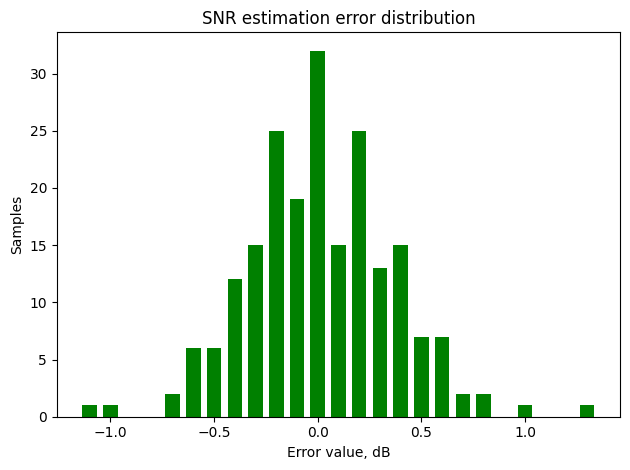

error percentage is: 0.1
Training a NN...
Loss: 0.06656584283099351
mse: 0.13288489580698573
r2: 0.9702005386937714
total # of iteration: 1744
Best Loss: 0.06656584283099351
Train duration: 3.31


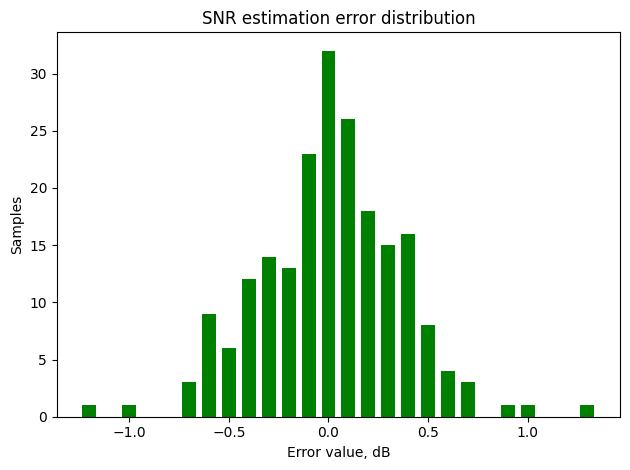

error percentage is: 0.15
Training a NN...
Loss: 0.07134477113296422
mse: 0.1424115414811709
r2: 0.9680641867222247
total # of iteration: 1829
Best Loss: 0.07134477113296422
Train duration: 3.51


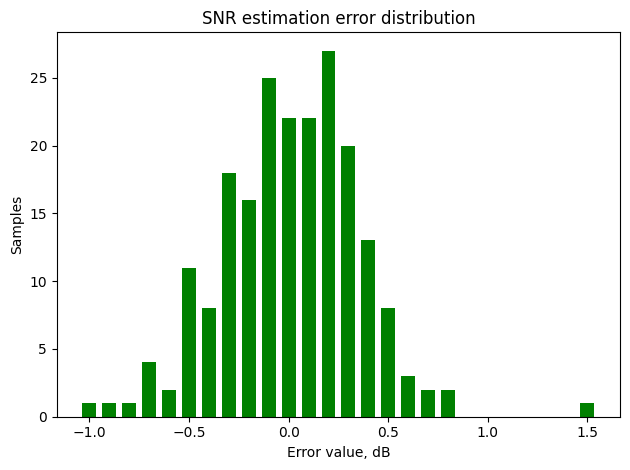

In [ ]:


percentage = [0.05,0.1,0.15]
#span_length_std = max_span_len * percentage
#print(span_length_std)

for per in percentage:
  new_datafile = 'SNR_dataset_0.25dB_per_km.txt'

  #F: Task 1b)
  new_spans, new_interferers, new_snr_values = read_dataset(new_datafile)

  new_y = np.array(new_snr_values)
  ############# ADD YOUR CODE BELOW #############
  max_span_len = -1
  for i in range(len(new_spans)):
      if max(new_spans[i]) > max_span_len:
        max_span_len = max(new_spans[i])

  print("error percentage is:", per)
  span_length_std = max_span_len * per
  X = extract_UNCERTAIN_features(new_spans, new_interferers, span_length_std)

  #test_train_func
  activation = 'logistic'
  neurons = 10
  layers = 2
  #solvers = ['sgd', 'adam']

  y = np.array(new_snr_values) #F: y is the array of outputs (labels) in our dataset; np.array() is needed to work with arrays instead of lists
  X_train, X_test, y_train, y_test = spliter(X,y)

  NNregr, train_duration = train_NN(X_train, y_train, activation, neurons, layers, 'adam')
  y_predicted = NNregr.predict(X_test)
  perf_eval(y_predicted,y_test)
